In [1]:
import os
import numpy as np
import pandas as pd


In [3]:
# Note: This notebook uses blast. To install on MacOS, run `brew install blast`.
# Set this to the location of your Swiss-Prot database
swiss_db_path = "/workspace/blast/swiss/swissprot"
# Maximum length of the IEDB epitopes used
max_epitope_len = 18
# Minimum length of the IEDB epitopes used
min_epitope_len = 9
# Total length of the samples used to create the model. The cleave location is at offset = generated_sample_len/2.
generated_sample_len = 20

data_dir = "/workspace/chipper_data/"
src_dir = "../src/"
models_dir = "../models/"
training_data_dir = data_dir + "training/"
testing_data_dir = data_dir + "testing/"

# Path to IEDB (http://iedb.org/) epitope export file
epitope_csv = training_data_dir + "epitope_table_export_1478815050.csv"
# Paths for models and predictions
LR_model_file = models_dir + "lr.model"
LR_predictions_file = training_data_dir + "LR_predictions.txt"
SVC_model_file = models_dir + "svc.model"
SVC_predictions_file = training_data_dir + "SVC_predictions.txt"
# File to save raw training data set to
raw_data_csv = training_data_dir + "training_set.csv"

In [4]:
generated_sample_len = 20

# Read and return the Saxon test set 
def fetch_testing_data():
    df = pd.DataFrame.from_csv(testing_data_dir + "saxova_in_vivo_mhc_1_ligands_dataset.csv")
    df = df[["Sequences", "Activity"]]
    df.columns = ["sequence", "is_cleaved"]
    df.is_cleaved[df.is_cleaved == -1] = 0
    return df

raw_testing_data = fetch_testing_data()
if generated_sample_len != 28:
    # Testing data is 28 residues in length, cut off excess residues
    trim_residues = (28 - generated_sample_len) / 2
    raw_testing_data["sequence"] = raw_testing_data.sequence.str[trim_residues:-trim_residues]

In [31]:
raw_training_data = pd.DataFrame.from_csv(raw_data_csv)
raw_training_data.shape[0]

51302

In [32]:
from aa_props import seq_to_aa_props

seq_validator = lambda seq: seq.find("U") == -1 and seq.find("'") == -1 and len(seq) == generated_sample_len

def fann_file(raw_data, filepath):
    invalid_samples = 0
    for row in raw_data.itertuples():
        if not seq_validator(row.sequence):
            invalid_samples += 1
    with open(filepath, "w") as out:
        out.write("%d %d 1\n" % (raw_data.shape[0]-invalid_samples, generated_sample_len * 50))
        for row in raw_data.itertuples():
            if seq_validator(row.sequence):
                out.write(" ".join([str(i) for i in seq_to_aa_props(row.sequence)]))
                out.write("\n")
                out.write("%d\n" % (row.is_cleaved))
        
fann_file(raw_testing_data, "/tmp/test.txt")
fann_file(raw_training_data, "/tmp/train.txt")

** Cutoff= 0.23 (MCC=0.616) **
             precision    recall  f1-score   support

          0       0.82      0.79      0.80       208
          1       0.80      0.83      0.81       208

avg / total       0.81      0.81      0.81       416

NN: sensitivity(recall)=79.6, specificity=82.0, precision=82.7


<IPython.core.display.Javascript object>


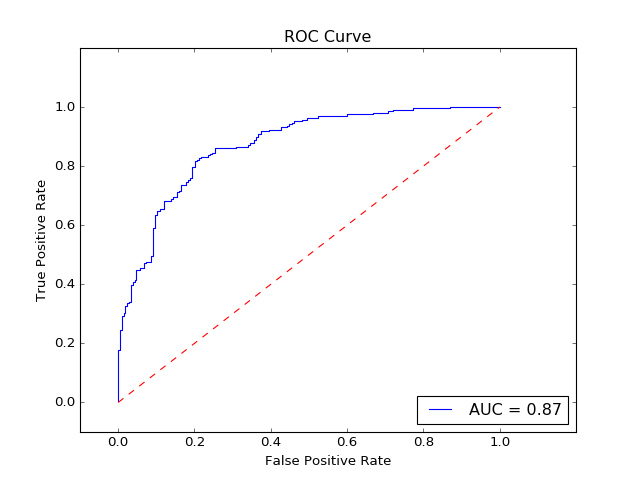

In [78]:
df = pd.DataFrame.from_csv("/workspace/berkeley/nn/vhse/out.txt")
real = df.real.astype("int")
predicted = df.pred

from sklearn.metrics import classification_report, matthews_corrcoef, confusion_matrix

classification_vector = lambda cutoff: [1 if pred >= cutoff else 0 for pred in predicted]

def find_best_mcc():
    best_mcc = 0.0
    best_cutoff = 0.0
    for i in range(1, 100):
        pred_cutoff = i/100.0
        mcc = matthews_corrcoef(real, classification_vector(pred_cutoff))
        if (mcc > best_mcc):
            best_mcc = mcc
            best_cutoff = pred_cutoff
    return (best_cutoff, best_mcc)

(best_cutoff, best_mcc) = find_best_mcc()
print "** Cutoff= %.2f (MCC=%.3f) **" % (best_cutoff, best_mcc)
print classification_report(real, classification_vector(best_cutoff))

def print_metrics(name, actual, predicted):
    ((tn, fn), (fp, tp)) = confusion_matrix(actual, predicted)
    sensitivity = 100.0 * tp / (tp + fn)
    specificity = 100.0 * tn / (tn + fp)
    precision = 100.0 * tp / (tp + fp)
    print "%s: sensitivity(recall)=%.1f, specificity=%.1f, precision=%.1f" % (name, sensitivity, specificity, precision)

print_metrics("NN", real, classification_vector(best_cutoff))

%matplotlib notebook
import matplotlib.pyplot as plt
from sklearn import svm, metrics

fpr, tpr, thresholds = metrics.roc_curve(real, predicted, pos_label=1)
roc_auc = metrics.roc_auc_score(real, predicted, average='macro', sample_weight=None)
plt.title('ROC Curve')
plt.plot(fpr, tpr, 'b', label='AUC = %0.2f'% (roc_auc))
plt.legend(loc='lower right')
plt.plot([0,1],[0,1],'r--')
plt.xlim([-0.1,1.2])
plt.ylim([-0.1,1.2])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')